In [ ]:
# This script will compare buy & sells of a given stock relative to the price action, 
# It is designed to analyze when I bought & sold a stock (Daytrading) vs the price action. 
# April 2025

In [522]:
import pandas as pd
import plotnine as p9
import yfinance as yf
from datetime import datetime, timedelta
import json
import unittest


In [510]:

class TestComputeSummary(unittest.TestCase):
    def setUp(self):
        # Sample data for testing
        self.df = pd.DataFrame({
            'Date': ['2025-05-09', '2025-05-09', '2025-05-09', '2025-05-09'],
            'Success': [True, False, True, False],
            'Stock_Total_Gain': [10.0, -5.0, 15.0, -10.0],
            'Stock_pShare_Gain': [2.0, -1.0, 3.0, -2.0]
        })

    def test_compute_summary(self):
        result = compute_summary(self.df)

        # Test daily summary
        daily_summary = result['daily_summary']
        self.assertEqual(len(daily_summary), 1)
        self.assertAlmostEqual(daily_summary['Daily_accuracy'].iloc[0], 0.5)
        self.assertAlmostEqual(daily_summary['Daily_total_gain'].iloc[0], 10.0)
        self.assertAlmostEqual(daily_summary['Daily_avg_gain'].iloc[0], 2.5)
        self.assertAlmostEqual(daily_summary['Daily_total_gain_per_share'].iloc[0], 2.0)

        # Test overall summary
        overall_summary = result['overall_summary']
        self.assertAlmostEqual(overall_summary['Overall_accuracy'].iloc[0], 0.5)
        self.assertAlmostEqual(overall_summary['Overall_total_gain'].iloc[0], 10.0)
        self.assertAlmostEqual(overall_summary['Overall_avg_gain'].iloc[0], 2.5)
        self.assertAlmostEqual(overall_summary['Overall_total_gain_per_share'].iloc[0], 2.0)

if __name__ == '__main__':
    unittest.main()

usage: ipykernel_launcher.py [-h] [-v] [-q] [--locals] [--durations N] [-f]
                             [-c] [-b] [-k TESTNAMEPATTERNS]
                             [tests ...]
ipykernel_launcher.py: error: argument -f/--failfast: ignored explicit argument '/Users/stevensmith/Library/Jupyter/runtime/kernel-v31b2c6f959dafaa9cc4e5b04521a9c71c80bac941.json'


SystemExit: 2

/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3678: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.


In [551]:
import unittest
import pandas as pd


def filter_time_window(data, universal_time_col='Datetime', filtering_time_col="FilledTime", units = "m",time_buffer=10):
    """
    Filter the data to include rows within a time interval of +/- time_buffer_minutes.

    Parameters:
    - data (pd.DataFrame): The input DataFrame containing a time column.
    - time_column (str): The name of the time column in the DataFrame.
    - time_buffer_minutes (int): The number of minutes to extend the time range.

    Returns:
    - pd.DataFrame: A filtered DataFrame within the specified time interval.
    """
    min_time = data[filtering_time_col].min() - pd.Timedelta(time_buffer,unit=units)
    max_time = data[filtering_time_col].max() + pd.Timedelta(time_buffer,unit=units)
    return data[(data[universal_time_col] >= min_time) & (data[universal_time_col] <= max_time)]


def format_orders(df):
    """
    Format the stock orders DataFrame by converting date columns to datetime and renaming columns.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing stock order records.
    
    Returns:
    - pd.DataFrame: The formatted DataFrame with renamed columns and datetime conversions.
    """
    #df.rename(columns={'Placed Time': 'PlacedTime', 'Symbol': 'Symbol', 'Side': 'Side', 'Avg Price': 'Avg Price'})
    df['Placed Time'] = pd.to_datetime(df['Placed Time'].str.replace(" EDT",""), format="%m/%d/%Y %H:%M:%S").dt.tz_localize('America/New_York')
    df['Filled Time'] = pd.to_datetime(df['Filled Time'].str.replace(" EDT",""), format="%m/%d/%Y %H:%M:%S").dt.tz_localize('America/New_York')

    df['Date'] = df['Placed Time'].dt.date
    df['Time'] = df['Placed Time'].dt.time    

    df['UID'] = df['Symbol'].astype(str) + "_" + df['Placed Time'].astype(str)
    
    df.rename(columns={'Order ID': 'OrderID', 'Symbol': 'Symbol', 'Side': 'Side', 'Avg Price': 'AvgPrice', 
                       'Quantity': 'Quantity', 'Status': 'Status', 'Placed Time': 'PlacedTime', 
                       'Filled Time': 'FilledTime'}, inplace=True)
    

    # Filter rows where the 'status' column is 'Filled'
    #filled_orders['FilledTime_dt']=pd.to_datetime(filled_orders['Filled Time'].str.replace(" EDT",""), format="%m/%d/%Y %H:%M:%S")
    #filled_orders['FilledTime_dt_ny'] = filled_orders['FilledTime_dt'].dt.tz_localize('America/New_York')
    #filled_orders.pivot(index=['Symbol', 'Placed Time'], columns='Side', values='Avg Price').reset_index()

    return df


def filter_stock_orders(df, cutoff_date=None,days=10):
    """
    Filter the stock orders DataFrame to include only filled orders within a specific time window.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing stock order records.
    
    Returns:
    - pd.DataFrame: The filtered DataFrame with filled orders within the specified time window.
    """

    if cutoff_date is None:
        cutoff_date = datetime.now() - timedelta(days=days)
        cutoff_date = pd.to_datetime(cutoff_date,format="%m/%d/%Y %H:%M:%S").tz_localize('America/New_York')
    
    # Filter the DataFrame for filled orders within the specified time window
    filtered_df = df[df['FilledTime'] > cutoff_date]
    
    return filtered_df

def pair_buy_sell(filled_orders_filtered):
    filled_orders_wide=filled_orders_filtered.pivot(index=['Symbol', 'PlacedTime'], values=['AvgPrice','FilledTime'], columns='Side').reset_index()#.rename(columns={'Buy': 'BuyTime', 'Sell': 'SellTime'})
    test_out = filled_orders_wide.columns.values
    filled_orders_wide.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in filled_orders_wide.columns.values]
    filled_orders_wide.rename(columns={'Symbol_': 'Symbol', 'PlacedTime_': 'PlacedTime'}, inplace=True)

    #filled_orders_wide = filled_orders_filtered.pivot(index=['Symbol', 'PlacedTime'], columns='Side', values='AvgPrice').reset_index()
    filled_orders_wide.sort_values(by=['Symbol', 'PlacedTime'], inplace=True)

    # Forward fill 'Buy' and backward fill 'Sell' to pair sequential times
    #AvgPrice_Buy	AvgPrice_Sell	FilledTime_Buy	FilledTime_Sell
    filled_orders_wide['Buy_Time_MM']=filled_orders_wide['AvgPrice_Buy'].isna()
    filled_orders_wide['Sell_Time_MM']=filled_orders_wide['AvgPrice_Sell'].isna()
    filled_orders_wide['AvgPrice_Buy'] = filled_orders_wide['AvgPrice_Buy'].fillna(method='ffill')
    filled_orders_wide['AvgPrice_Sell'] = filled_orders_wide['AvgPrice_Sell'].fillna(method='bfill')
    filled_orders_wide['UID'] = filled_orders_wide['Symbol'].astype(str) + "_" + filled_orders_wide['PlacedTime'].astype(str)

    filled_orders_wide.drop(columns=['Symbol','PlacedTime'], inplace=True)


    return filled_orders_wide,test_out


def pair_buy_sell_mlindx(filled_orders_filtered):
    filled_orders_wide=filled_orders_filtered.pivot(index=['Symbol', 'PlacedTime'], values=['AvgPrice','FilledTime'], columns='Side').reset_index()#.rename(columns={'Buy': 'BuyTime', 'Sell': 'SellTime'})
    test_out = filled_orders_wide.columns.values
    #filled_orders_wide.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in filled_orders_wide.columns.values]
    #filled_orders_wide.rename(columns={'Symbol_': 'Symbol', 'PlacedTime_': 'PlacedTime'}, inplace=True)

    #filled_orders_wide = filled_orders_filtered.pivot(index=['Symbol', 'PlacedTime'], columns='Side', values='AvgPrice').reset_index()
    filled_orders_wide.sort_values(by=[('Symbol',), ('PlacedTime',)], inplace=True)

    # Forward fill 'Buy' and backward fill 'Sell' to pair sequential times
    #AvgPrice_Buy	AvgPrice_Sell	FilledTime_Buy	FilledTime_Sell
    #TODO: test this on data without OCO orders. This should still work assuming an outstanding order is closed before another one opened. 
    #However this may not work with partial sells. 
    # Why are we doing a wide pivot here? It is only to make stats easier to compute. However, stats can be computed in aggregate. 
    filled_orders_wide[('TimeMM','Buy')]=filled_orders_wide[('AvgPrice','Buy')].isna()
    filled_orders_wide[('TimeMM','Sell')]=filled_orders_wide[('AvgPrice','Sell')].isna()
    filled_orders_wide[('AvgPrice','Buy')] = filled_orders_wide[('AvgPrice','Buy')].fillna(method='ffill')
    filled_orders_wide[('AvgPrice','Sell')] = filled_orders_wide[('AvgPrice','Sell')].fillna(method='bfill')
    filled_orders_wide[('UID','')] = filled_orders_wide[('Symbol',)].astype(str) + "_" + filled_orders_wide[('PlacedTime',)].astype(str)

    filled_orders_wide.drop(columns=[('Symbol',),('PlacedTime',)], inplace=True)


    return filled_orders_wide,test_out


def compute_stats(df):

    df['Gain_per_share'] = df['AvgPrice_Sell'] - df['AvgPrice_Buy']
    df['Gain_total'] = df['Gain_per_share'] * df['Filled']
    df['Success'] = df['Gain_total'] > 0

    return df


def compute_stats_long(df):
    # compute total gains - for each share & day, sum up the price * shares (sell - buy)
    #shares * sell - shares * buy = (shres1* buy1) - (shres2*sell2) - (shares3*price3)
    #Name	Symbol	Side	Status	Filled	Total Qty	Price	AvgPrice	Time-in-Force	PlacedTime	FilledTime	Date	Time	UID
    df.loc[df['Side'] == 'Buy','AvgPrice'] = -df.loc[df['Side'] == 'Buy','AvgPrice']
  
    df['Total_Price'] = df['Filled'] * df['AvgPrice'] 
    df_summary = df.groupby(['Symbol','Date']).agg({'Total_Price':'sum','AvgPrice':'sum'}).reset_index().rename(columns={'Total_Price':'Stock_Total_Gain','AvgPrice':'Stock_pShare_Gain'})
    df_summary['Success'] = df_summary['Stock_Total_Gain']>0 #filled_orders_w_stats = compute_stats_long(filled_orders_filtered)
    
    return df, df_summary

# def compute_stats_mlindx(df):
#     df[('Gain_per_share','computed')] = df[('AvgPrice','Sell')] - df[('AvgPrice','Buy')]
#     df[('Gain_total','computed')] = df[('Gain_per_share','computed')] * df[('Filled',)]
#     df[('Success','computed')] = df[('Gain_total','computed')] > 0

#     return df




def generate_candlestick_plot(stock_order_df, timedata_width=2.5, date = "", stock_symbol=""):
    """
    Generate a candlestick plot using plotnine.

    Parameters:
    - stock_order_df (pd.DataFrame): A DataFrame containing stock data with columns 'Datetime', 'Open', 'High', 'Low', and 'Close' and stock buy/sell orders.

    Returns:
    - plotnine.ggplot.ggplot: A candlestick plot.
    
    """

    interval = timedata_width * 2
    stock_order_df["hour_min"] = stock_order_df['Datetime'].dt.strftime('%H:%M:%S') #TODO figure out a way to use hour_min in x axis
    candlestick_plot = (
        p9.ggplot(stock_order_df, p9.aes(x='Datetime')) +
        p9.geom_segment(p9.aes(x='Datetime', xend='Datetime', y='Low', yend='High'), color='black') +

        p9.geom_rect(
            p9.aes(
            xmin=f"Datetime - pd.Timedelta(minutes={timedata_width})",
            xmax=f"Datetime + pd.Timedelta(minutes={timedata_width})", 
            ymin='Open', 
            ymax='Close', 
            fill='Close > Open'
            ),
            color='black'
        ) +
        p9.geom_point(p9.aes(x='Datetime', y='AvgPrice', color="Side"), size=2) +
        p9.scale_fill_manual(values={True: 'green', False: 'red'}) +
        p9.scale_color_manual(values={"Buy": 'blue', "Sell": 'orange'}) +
        p9.labs(title="Candlestick Chart", x="Datetime", y="Price") +
        p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1)) +
        p9.scale_x_datetime(date_breaks='5 minutes', date_labels='%H:%M') +
        p9.ggtitle(f"Candlestick Chart for {stock_symbol} on {date} @ {interval} min interval")
        )   
    candlestick_plot.save(f"candlestick_plot_{date}_{stock_symbol}_{interval}mins.png", dpi=300)
    return candlestick_plot




def compute_summary(df):

    # Compute daily accuracy
    daily_success = df.groupby('Date')['Success'].sum().reset_index(name='Daily_success')
    total_trades = df.groupby('Date')['Success'].count().reset_index(name='Total_trades')
    daily_accuracy = daily_success.merge(total_trades, on='Date')
    daily_accuracy['Daily_accuracy'] = daily_accuracy['Daily_success'] /daily_accuracy['Total_trades']  #df.groupby('Date').apply(lambda x: x['Success'].sum() / len(x)).reset_index(name='Daily_accuracy')


    #daily_accuracy_detailed = daily_accuracy.merge(daily_success, on='Date').merge(total_trades, on='Date')

    # Compute daily total gain
    daily_total_gain = df.groupby('Date')['Stock_Total_Gain'].sum().reset_index(name='Daily_total_gain')

    # Compute per-share total gain 
    daily_total_gain_normalized = df.groupby('Date')['Stock_pShare_Gain'].sum().reset_index(name='Daily_total_gain_per_share')


    # Compute daily average gain
    daily_avg_gain = df.groupby('Date')['Stock_Total_Gain'].mean().reset_index(name='Daily_avg_gain')


    # Merge all summaries into a single DataFrame
    daily_summary = daily_accuracy.merge(daily_total_gain).merge(daily_avg_gain).merge(
        daily_total_gain_normalized)


    # compute overalls: 
    overall_accuracy = df['Success'].sum() / len(df['Success'])
    overall_total_gain = df['Stock_Total_Gain'].sum()
    overall_total_gain_per_share = df['Stock_pShare_Gain'].sum()
    overall_avg_gain = df['Stock_Total_Gain'].mean()
    overall_summary = pd.DataFrame({
        'Overall_accuracy': [overall_accuracy],
        'Overall_total_gain': [overall_total_gain],
        'Overall_avg_gain': [overall_avg_gain],
        'Overall_total_gain_per_share': [overall_total_gain_per_share],
    })


    return {'daily_summary': daily_summary,'overall_summary': overall_summary}


def flatten_columns(df,delimiter='_',rename_mapping=None):  
    """
    Flatten the multi-level columns of a DataFrame into single-level columns.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame with multi-level columns.
    - delimiter (str): The delimiter to use for flattening the columns (default is '_').
    - rename_mapping (dict): Optional mapping to rename columns after flattening.
    
    Returns:
    - pd.DataFrame: The DataFrame with flattened columns and optional renaming.
    """

    df.columns = [delimiter.join(filter(None, col)).strip() for col in df.columns.values]
    if rename_mapping is not None:
        df.rename(columns=rename_mapping, inplace=True)
    return df

def get_stock_data_wrapper(symbol, start_date, end_date, stock_interval="1m",download_file_path=None,dl_info=False,load_from_file = None):
    if load_from_file is not None:
        try:
            # Load the data from the specified file
            print("Downloading from previous download")
            stock_df = pd.read_csv(load_from_file, sep="\t")
            return stock_df
        except FileNotFoundError:
            #TODO: execute the else statement (e.g., download the data) if the file is not found
            print(f"File {load_from_file} not found. Please check the file path. Will attempt to download data from yFinance.")
            return get_stock_data(symbol=symbol, start_date=start_date, end_date=end_date, stock_interval=stock_interval,
                       download_file_path=download_file_path,dl_info=dl_info)
            
    else:
        print("Downloading from yFinance")
        return get_stock_data(symbol=symbol, start_date=start_date, end_date=end_date, stock_interval=stock_interval,
                       download_file_path=download_file_path,dl_info=dl_info)


def get_stock_data(symbol, start_date, end_date, stock_interval="1m",download_file_path=None,dl_info=False):
    """
    Fetch historical stock data for a given symbol and date range.
    
    Parameters:
    - symbol (str): The stock symbol to fetch data for.
    - start_date (str): The start date in 'YYYY-MM-DD' format.
    - end_date (str): The end date in 'YYYY-MM-DD' format. 
    - stock_interval (str): The interval for the stock data (default is '1m'). TODO: data validation e.g. '1m', '5m', '15m', '1h', '1d'.
    - download_file_path (str): Optional file path to save the downloaded data as a TSV file.
    - dl_info (bool): Optional flag to save additional information about the downloaded data in a JSON file. 'download_file_path' must be provided for this to work.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the historical stock data. Also saves the data to a TSV file if download_file_path is provided.
    """

    stock_data = yf.Ticker(symbol)
    stock_info = stock_data.info
    try:
        stock_df = stock_data.history(period="1d", interval=stock_interval, start=start_date, end=end_date,raise_errors=True).reset_index()
    except Exception as e:
        print(f"Could not fetch stock data for {symbol}: {e}")
        return None

    # convert into multiindex for downstream merging
    #stock_df.columns = pd.MultiIndex.from_product([stock_df.columns, ['stock_info']])
    if download_file_path is not None:
        stock_df.to_csv(download_file_path, index=False,sep="\t")
        if dl_info:
            # Convert to JSON and write to a file
            with open(download_file_path.replace(".tsv",".json"), "w") as json_file:
                json.dump(stock_info, json_file, indent=4)
    return stock_df


 
def combine_data(stock_df,order_df,stock_key='Datetime', order_key='FilledTime_dt_ny',direction='nearest',tol_interval="5m"):
    if stock_df is None or order_df is None:
        print("Not combining data: Both stock_df and order_df must be provided. stock history likelky missing")
        return None
    # Ensure both dataframes are sorted by time
    stock_dat = stock_df.sort_values(by=stock_key)
    filled_orders = order_df.sort_values(by=order_key)
    display(stock_dat)
    display(filled_orders)

    # Perform an asof merge to find the closest time
    #TODO resolve whe maps to multiple times
    merged_df = pd.merge_asof(
        stock_dat,
        filled_orders,
        left_on=stock_key,
        right_on=order_key,
        direction=direction,
        tolerance=pd.Timedelta(tol_interval)
    )

    return merged_df




In [531]:
# Load the stock orders file
#stock_order_records = pd.read_csv("~/Downloads/Webull_Orders_Records.noOCO.csv")
buy_records ="/Users/stevensmith/Projects/Random_Projects/stock_reccomender/Webull_Orders_Records_05092025.csv"
stock_order_records = pd.read_csv(buy_records)
stock_orders_formatted = format_orders(stock_order_records)
filled_orders = stock_orders_formatted[stock_orders_formatted['Status'] == 'Filled']
filled_orders_filtered = filter_stock_orders(filled_orders,days=100)

filled_orders_filtered,filled_orders_w_stats  = compute_stats_long(filled_orders_filtered)
display(filled_orders_filtered)
display(filled_orders_w_stats.sort_values(by=['Date','Symbol']))
filled_orders_summary= compute_summary(filled_orders_w_stats)
display(filled_orders_summary)

filled_orders_filtered[filled_orders_filtered['Date']=="2025-05-09"]#.to_csv("filled_orders_filtered_2025-05-09.csv",index=False)']


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price
0,Abits Group Inc.,ABTS,Sell,Filled,1,1,@6.16,6.16,GTC,2025-05-09 15:41:37-04:00,2025-05-09 15:41:37-04:00,2025-05-09,15:41:37,ABTS_2025-05-09 15:41:37-04:00,6.16
1,Abits Group Inc.,ABTS,Buy,Filled,1,1,@6.34,-6.34,GTC,2025-05-09 15:41:31-04:00,2025-05-09 15:41:31-04:00,2025-05-09,15:41:31,ABTS_2025-05-09 15:41:31-04:00,-6.34
2,Abits Group Inc.,ABTS,Sell,Filled,1,1,@4.95,4.95,GTC,2025-05-09 15:38:17-04:00,2025-05-09 15:38:17-04:00,2025-05-09,15:38:17,ABTS_2025-05-09 15:38:17-04:00,4.95
3,Abits Group Inc.,ABTS,Buy,Filled,1,1,@5.09,-5.09,GTC,2025-05-09 15:38:15-04:00,2025-05-09 15:38:15-04:00,2025-05-09,15:38:15,ABTS_2025-05-09 15:38:15-04:00,-5.09
4,Abits Group Inc.,ABTS,Sell,Filled,1,1,@4.74,4.74,GTC,2025-05-09 15:37:52-04:00,2025-05-09 15:37:52-04:00,2025-05-09,15:37:52,ABTS_2025-05-09 15:37:52-04:00,4.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,Sonoma Pharmaceu,SNOA,Buy,Filled,1,1,@3.90,-3.90,GTC,2025-04-22 16:25:49-04:00,2025-04-22 16:25:49-04:00,2025-04-22,16:25:49,SNOA_2025-04-22 16:25:49-04:00,-3.90
256,Sonoma Pharmaceu,SNOA,Sell,Filled,1,1,@3.45,3.45,GTC,2025-04-22 16:09:59-04:00,2025-04-22 16:09:59-04:00,2025-04-22,16:09:59,SNOA_2025-04-22 16:09:59-04:00,3.45
257,Sonoma Pharmaceu,SNOA,Buy,Filled,1,1,@3.64,-3.64,GTC,2025-04-22 16:05:10-04:00,2025-04-22 16:05:12-04:00,2025-04-22,16:05:10,SNOA_2025-04-22 16:05:10-04:00,-3.64
284,Splash Beverage Group Inc,SBEV,Sell,Filled,1,1,@5.55,5.55,GTC,2025-04-21 15:33:59-04:00,2025-04-21 15:44:43-04:00,2025-04-21,15:33:59,SBEV_2025-04-21 15:33:59-04:00,5.55


,Symbol,Date,Stock_Total_Gain,Stock_pShare_Gain,Success
25,SBEV,2025-04-21,0.10,0.10,True
27,SNOA,2025-04-22,-0.14,-0.14,False
2,AREB,2025-04-23,0.06,0.06,True
5,CEP,2025-04-23,0.64,0.64,True
9,ENSC,2025-04-23,0.34,0.34,True
4,BCTX,2025-04-24,-0.30,-0.30,False
6,CEP,2025-04-24,0.64,0.64,True
26,SERV,2025-04-24,0.02,0.02,True
7,CEP,2025-04-25,0.39,0.39,True
30,UPXI,2025-04-25,0.29,0.29,True


{'daily_summary':           Date  Daily_success  Total_trades  Daily_accuracy  Daily_total_gain  \
 0   2025-04-21              1             1        1.000000              0.10   
 1   2025-04-22              0             1        0.000000             -0.14   
 2   2025-04-23              3             3        1.000000              1.04   
 3   2025-04-24              2             3        0.666667              0.36   
 4   2025-04-25              2             2        1.000000              0.68   
 5   2025-04-28              1             2        0.500000              0.49   
 6   2025-04-29              1             2        0.500000             -0.07   
 7   2025-04-30              0             1        0.000000             -2.05   
 8   2025-05-02              2             2        1.000000              0.47   
 9   2025-05-05              2             4        0.500000              0.72   
 10  2025-05-06              1             2        0.500000             -0.81   

,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price


Get historical stock data


In [ ]:
dates = filled_orders_filtered['Date'].unique()
#dates = filled_orders_w_stats_mlindx[('Date',)  ].unique()
for start_date in dates:
    # Filter the DataFrame for the current date
    #filtered_df = filled_orders_filtered[filled_orders_filtered['FilledTime'].dt.date == start_date]
    filtered_df = filled_orders_filtered[filled_orders_filtered['Date'] == start_date]
    
    for selected_symbol in filtered_df['Symbol'].unique():
        #print(f"Orders for {selected_symbol}:")
        filtered_synbol_date_df = filtered_df[filtered_df['Symbol'] == selected_symbol]
        end_date = start_date + pd.Timedelta(days=1)

        interval_mins = 1 # TODO: make this a parameter/data validation

        interval = f"{interval_mins}m"
        stock_fn = f"/Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/stock_order_{start_date}_{selected_symbol}_{interval}.tsv"
    
        stock_dat = get_stock_data_wrapper(selected_symbol, start_date=start_date, end_date=end_date, stock_interval=interval,download_file_path=stock_fn, dl_info=True,load_from_file=stock_fn)
        #filled_orders[filled_orders['Symbol']==selected_symbol].to_csv(f"stock_order_df_{start_date}_{selected_symbol}.tsv", index=False,sep="\t")
        #TODO: fix loading from previous file. I think the date/time format is not being correctly loaded


        stock_order_df = combine_data(stock_dat, filtered_synbol_date_df,tol_interval=interval,direction='backward',stock_key='Datetime', order_key='FilledTime')

        if stock_order_df is not None:

            stock_order_df.loc[stock_order_df['Side']=='Buy','AvgPrice'] = -stock_order_df.loc[stock_order_df['Side']=='Buy','AvgPrice']

            stock_order_df.to_csv(f"stock_order_price_df_{start_date}_{selected_symbol}.tsv", index=False,sep="\t")

            generate_candlestick_plot(filter_time_window(stock_order_df),timedata_width=interval_mins/2,date=start_date ,stock_symbol=selected_symbol)
        else:
            print(f"Stock data for {selected_symbol} on {start_date} not found. Skipping candlestick plot generation.")
            continue


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2025-05-09 09:30:00-04:00,2.4600,2.4600,2.4600,2.4600,0,0.0,0.0
1,2025-05-09 09:39:00-04:00,2.4800,2.4800,2.4800,2.4800,628,0.0,0.0
2,2025-05-09 09:40:00-04:00,2.4100,2.4100,2.4100,2.4100,515,0.0,0.0
3,2025-05-09 09:41:00-04:00,2.4000,2.4000,2.4000,2.4000,163,0.0,0.0
4,2025-05-09 09:42:00-04:00,2.4100,2.4100,2.4100,2.4100,424,0.0,0.0
5,2025-05-09 09:49:00-04:00,2.4100,2.4100,2.4100,2.4100,200,0.0,0.0
6,2025-05-09 09:52:00-04:00,2.4000,2.4000,2.4000,2.4000,582,0.0,0.0
7,2025-05-09 10:02:00-04:00,2.4000,2.4433,2.4000,2.4433,1993,0.0,0.0
8,2025-05-09 10:06:00-04:00,2.5000,2.5000,2.5000,2.5000,2064,0.0,0.0
9,2025-05-09 10:07:00-04:00,2.5100,2.5100,2.5100,2.5100,420,0.0,0.0


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price
5,Abits Group Inc.,ABTS,Buy,Filled,1,1,@4.00,-4.00,GTC,2025-05-09 15:37:11-04:00,2025-05-09 15:37:11-04:00,2025-05-09,15:37:11,ABTS_2025-05-09 15:37:11-04:00,-4.00
4,Abits Group Inc.,ABTS,Sell,Filled,1,1,@4.74,4.74,GTC,2025-05-09 15:37:52-04:00,2025-05-09 15:37:52-04:00,2025-05-09,15:37:52,ABTS_2025-05-09 15:37:52-04:00,4.74
3,Abits Group Inc.,ABTS,Buy,Filled,1,1,@5.09,-5.09,GTC,2025-05-09 15:38:15-04:00,2025-05-09 15:38:15-04:00,2025-05-09,15:38:15,ABTS_2025-05-09 15:38:15-04:00,-5.09
2,Abits Group Inc.,ABTS,Sell,Filled,1,1,@4.95,4.95,GTC,2025-05-09 15:38:17-04:00,2025-05-09 15:38:17-04:00,2025-05-09,15:38:17,ABTS_2025-05-09 15:38:17-04:00,4.95
1,Abits Group Inc.,ABTS,Buy,Filled,1,1,@6.34,-6.34,GTC,2025-05-09 15:41:31-04:00,2025-05-09 15:41:31-04:00,2025-05-09,15:41:31,ABTS_2025-05-09 15:41:31-04:00,-6.34
0,Abits Group Inc.,ABTS,Sell,Filled,1,1,@6.16,6.16,GTC,2025-05-09 15:41:37-04:00,2025-05-09 15:41:37-04:00,2025-05-09,15:41:37,ABTS_2025-05-09 15:41:37-04:00,6.16


MergeError: Incompatible merge dtype, datetime64[ns, America/New_York] and dtype('O'), both sides must have numeric dtype

In [546]:
try:
    yf.Ticker('WBUY').history(period="1d", interval="1m", start="2025-05-09", end="2025-05-10",raise_errors=True).reset_index()
except Exception as e:
    print(f"Error fetching data for WBUY: {e}")
    # Handle the error as needed


Error fetching data for WBUY: $WBUY: possibly delisted; no timezone found


In [480]:
filled_orders_filtered

,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price
0,Pasithea Therapeutics Corp,KTTA,Buy,Filled,3,3,@3.12,3.12,GTC,2025-05-06 09:51:25-04:00,2025-05-06 09:51:28-04:00,2025-05-06,09:51:25,KTTA_2025-05-06 09:51:25-04:00,9.36
1,Pasithea Therapeutics Corp,KTTA,Sell,Filled,3,3,@3.23,-3.23,GTC,2025-05-06 09:51:25-04:00,2025-05-06 09:54:04-04:00,2025-05-06,09:51:25,KTTA_2025-05-06 09:51:25-04:00,-9.69
3,Pasithea Therapeutics Corp,KTTA,Buy,Filled,3,3,@3.08,3.08,GTC,2025-05-06 09:49:05-04:00,2025-05-06 09:49:05-04:00,2025-05-06,09:49:05,KTTA_2025-05-06 09:49:05-04:00,9.24
4,Pasithea Therapeutics Corp,KTTA,Sell,Filled,3,3,@2.95,-2.95,GTC,2025-05-06 09:49:05-04:00,2025-05-06 09:50:00-04:00,2025-05-06,09:49:05,KTTA_2025-05-06 09:49:05-04:00,-8.85
6,Pasithea Therapeutics Corp,KTTA,Buy,Filled,3,3,@2.68,2.68,GTC,2025-05-06 09:43:22-04:00,2025-05-06 09:43:22-04:00,2025-05-06,09:43:22,KTTA_2025-05-06 09:43:22-04:00,8.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,Sonoma Pharmaceu,SNOA,Buy,Filled,1,1,@3.90,3.90,GTC,2025-04-22 16:25:49-04:00,2025-04-22 16:25:49-04:00,2025-04-22,16:25:49,SNOA_2025-04-22 16:25:49-04:00,3.90
131,Sonoma Pharmaceu,SNOA,Sell,Filled,1,1,@3.45,-3.45,GTC,2025-04-22 16:09:59-04:00,2025-04-22 16:09:59-04:00,2025-04-22,16:09:59,SNOA_2025-04-22 16:09:59-04:00,-3.45
132,Sonoma Pharmaceu,SNOA,Buy,Filled,1,1,@3.64,3.64,GTC,2025-04-22 16:05:10-04:00,2025-04-22 16:05:12-04:00,2025-04-22,16:05:10,SNOA_2025-04-22 16:05:10-04:00,3.64
159,Splash Beverage Group Inc,SBEV,Sell,Filled,1,1,@5.55,-5.55,GTC,2025-04-21 15:33:59-04:00,2025-04-21 15:44:43-04:00,2025-04-21,15:33:59,SBEV_2025-04-21 15:33:59-04:00,-5.55


In [482]:
daily_gain_per_stock = filled_orders_filtered.groupby(['Date','Symbol']).agg({'Total_Price':'sum','AvgPrice':'sum'}).reset_index().rename(columns={'Total_Price':'Stock_Total_Gain','AvgPrice':'Stock_pShare_Gain'})

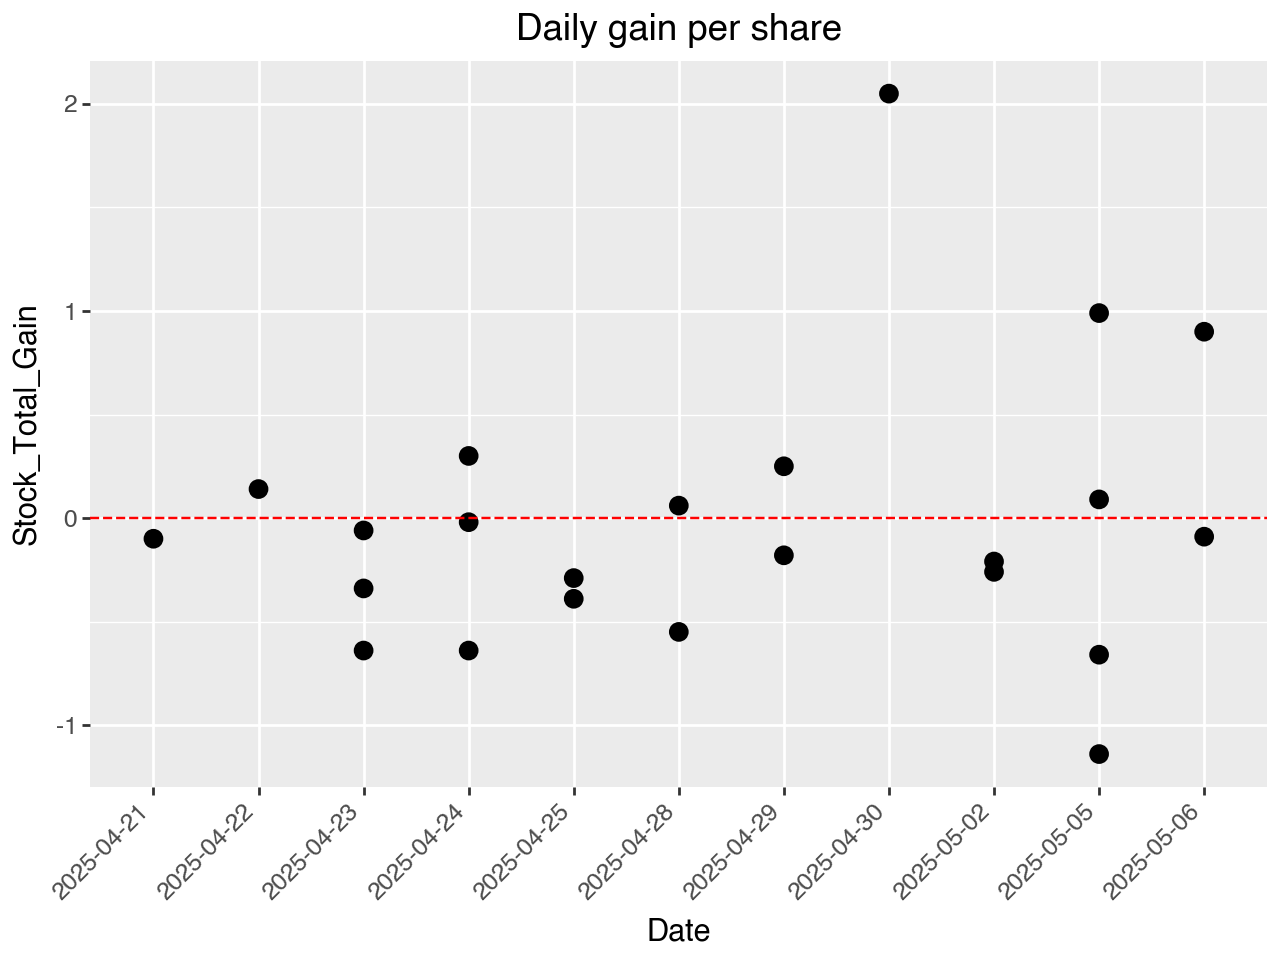

In [500]:
(p9.ggplot(filled_orders_summary['daily_summary'], p9.aes(x='Date', y='Daily_accuracy')) +
    p9.geom_point(size=3) +
    p9.labs(title='Daily Accuracy', x='Date', y='Accuracy') +
    p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
)

filled_orders_summary['daily_summary']
(p9.ggplot(filled_orders_summary['daily_summary'], p9.aes(x='Date', y='Daily_total_gain')) +
    p9.geom_bar(stat="identity") +
    p9.labs(title='Daily Gain') +
    p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
)

filled_orders_summary['daily_summary']
(p9.ggplot(filled_orders_summary['daily_summary'], p9.aes(x='Date', y='Daily_total_gain_per_share')) +
    p9.geom_bar(stat="identity") +
    p9.labs(title='Daily Gain - per share') +
    p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
)


(p9.ggplot(daily_gain_per_stock, p9.aes(x='Date', y='Stock_Total_Gain')) +
    p9.geom_point(size=3) +
    p9.labs(title='Daily gain per share') +
    p9.geom_hline(yintercept=0, linetype='dashed', color='red') +
    p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
)

